In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Data manipulation
import numpy as np
from sklearn.model_selection import train_test_split  # not needed here because the data is already splitted.
from sklearn.metrics import classification_report  # Recall, F1-Score, precission, support, accuracy and more
from sklearn.utils import shuffle  # for shuffling train and test data
from PIL import Image, ImageEnhance

# ML libraries
from tensorflow import keras  # keras.utils.model_plot to see the model
from tensorflow.keras.models import Sequential  
from tensorflow.keras.applications import VGG16  # transfer learning, base model. 
from tensorflow.keras.optimizers import Adam  # Adapt momentum. It uses the benefits of RMSprop and Gradient Descent with momentum. Hyper params: learning rate, beta for momentum
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img  # to load images.

# Visualization
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
train_dir = 'D://RiceCrop_DS/50_img_DS/train/'
val_dir = 'D://RiceCrop_DS/50_img_DS/validation/'
test_dir = 'D://RiceCrop_DS/50_img_DS/test/'

unique_labels1 = os.listdir(train_dir)
unique_labels2 = ['HEALTHY', 'DISEASED']  # we have labels for bacteria and virus in the label, so we can classify as virus, bacteria, normal

train_paths = []
train_labels = []
val_paths = []
val_labels = []
test_paths = []
test_labels = []

directories = {'train_dir':train_dir, 'val_dir':val_dir, 'test_dir':test_dir}
paths_dict = {'train_paths':train_paths, 'val_paths':val_paths, 'test_paths':test_paths}
labels_dict = {'train_labels':train_labels, 'val_labels':val_labels, 'test_labels':test_labels}


for data in ['train', 'val', 'test']: 
    directory = directories[data+'_dir']
    for label in unique_labels1:
        for image in os.listdir(directory + label):
            paths_dict[data+'_paths'].append(directory + label + '/' + image)
            labels_dict[data+'_labels'].append(label)

# data is stored in an order that might one group be the first and the other second. So we need to shuffle them so there is no pattern for it.
train_paths, train_labels = shuffle(train_paths, train_labels)
val_paths, val_labels = shuffle(val_paths, val_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)


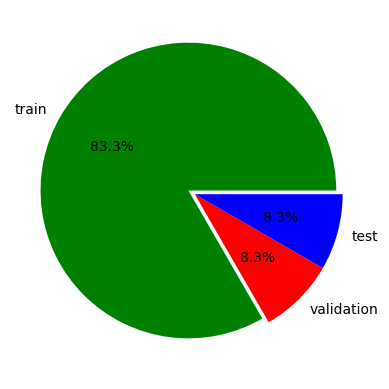

In [4]:
plt.pie([len(train_paths), len(val_paths), len(test_paths)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['green', 'red', 'blue'], explode=(0.05, 0, 0))
plt.show()

In [5]:
data_paths = []
data_paths.extend(train_paths)
data_paths.extend(val_paths)
data_paths.extend(test_paths)
data_labels = []
data_labels.extend(train_labels)
data_labels.extend(val_labels)
data_labels.extend(test_labels)
train_paths, test_paths, train_labels, test_labels = train_test_split(data_paths,data_labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(data_paths,data_labels, test_size=0.25, random_state=42)

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.8, 1.2))
    image = np.array(image)/255.0  # normalize
    return image

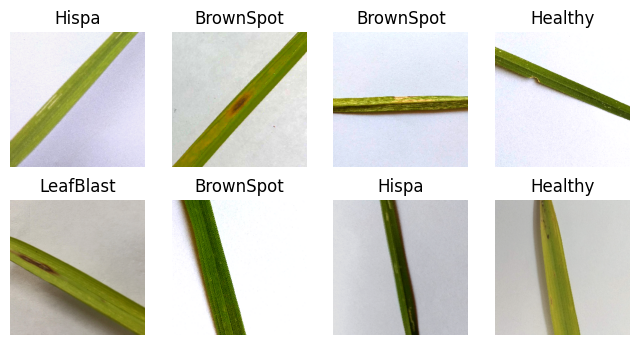

In [7]:
IMAGE_SIZE = 256

def load_augmented_image(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)
    
images = load_augmented_image(train_paths[50: 59])
labels = train_labels
fig = plt.figure(figsize=(8,4))
for i in range(8):
    fig.add_subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [8]:
def encode_labels(labels, unique_labels):
    encoded = []
    for label in labels:
        encoded.append(unique_labels.index(label))
    return np.array(encoded)

def decode_labels(encoded, unique_labels):
    labels = []
    for idx in encoded:
        labels.append(unique_labels[idx])
    return np.array(labels)

In [9]:
def datagen(paths, labels, batch_size=12, epochs=1, unique_labels=None):
    """
    Divide each epoch to some steps and in each step of each epoch return the mini batch data.
    """
    for _ in range(epochs):
        for sample_idx in range(0, len(paths), batch_size):
            batch_images = load_augmented_image(paths[sample_idx: sample_idx + batch_size])
            batch_labels = encode_labels(labels[sample_idx: sample_idx + batch_size], unique_labels)
            yield batch_images, batch_labels

In [10]:
base_model = VGG16(weights='imagenet', include_top = False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

for i in range(3):
    base_model.layers[-2-i].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels1), activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 18,909,636
Trainable params: 11,274,372
No

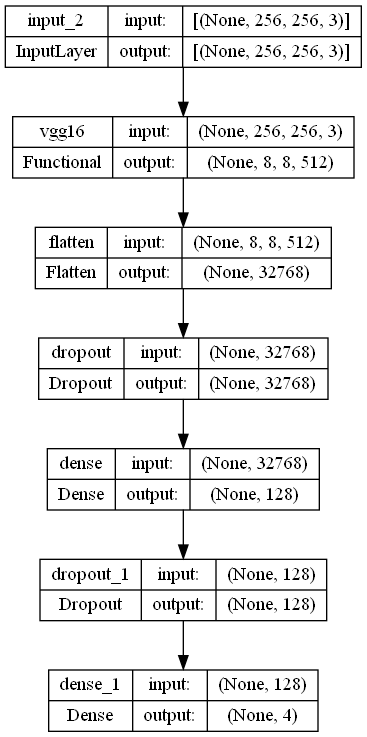

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

In [28]:
batch_size = 20
steps = len(train_labels)//batch_size
epochs=20

def train_model(batch_size, steps, epochs, unique_labels):
    history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs, unique_labels=unique_labels),
                       epochs=epochs, steps_per_epoch=steps)
    return history

history = train_model(batch_size, steps, epochs, unique_labels1)

Epoch 1/20
9/9 [==============================] - 55s 6s/step - loss: 0.4606 - sparse_categorical_accuracy: 0.8278
Epoch 2/20
9/9 [==============================] - 54s 6s/step - loss: 0.3674 - sparse_categorical_accuracy: 0.9056
Epoch 3/20
9/9 [==============================] - 57s 6s/step - loss: 0.3501 - sparse_categorical_accuracy: 0.8889
Epoch 4/20
9/9 [==============================] - 56s 6s/step - loss: 0.3272 - sparse_categorical_accuracy: 0.9111
Epoch 5/20
9/9 [==============================] - 55s 6s/step - loss: 0.2928 - sparse_categorical_accuracy: 0.9333
Epoch 6/20
9/9 [==============================] - 56s 6s/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9222
Epoch 7/20
9/9 [==============================] - 56s 6s/step - loss: 0.2327 - sparse_categorical_accuracy: 0.9556
Epoch 8/20
9/9 [==============================] - 55s 6s/step - loss: 0.2190 - sparse_categorical_accuracy: 0.9389
Epoch 9/20
9/9 [==============================] - 56s 6s/step - loss: 0.1956 - s

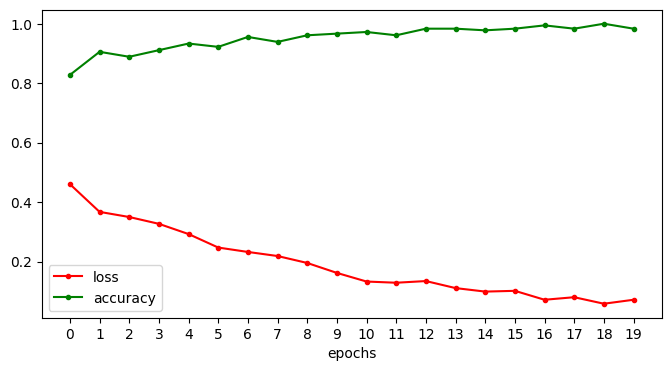

In [29]:
def plot_trining_loss(history, epochs):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], '.r-', label='loss')
    plt.plot(history.history['sparse_categorical_accuracy'], '.g-', label='accuracy')
    plt.xticks(ticks=range(epochs))
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

plot_trining_loss(history, epochs)

In [30]:
batch_size =16
steps = len(val_labels)//batch_size
epochs=20


def predict_labels(model, paths, labels, batch_size, steps, epochs, unique_labels):
    y_pred = []
    y_true = []
    # for each mini batch get x,y and predict labels and then append to y_pred
    for x,y in tqdm(datagen(paths, labels, batch_size=batch_size, epochs=epochs, unique_labels=unique_labels), total=steps):
        pred = model.predict(x)  
        pred = np.argmax(pred, axis=-1)
        y_pred.extend(decode_labels(pred, unique_labels))
        y_true.extend(decode_labels(y, unique_labels))
    return y_true, y_pred

y_true, y_pred = predict_labels(model, val_paths, val_labels, batch_size, steps, epochs, unique_labels1)

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


 33%|███▎      | 1/3 [00:04<00:09,  4.73s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████▋   | 2/3 [00:09<00:04,  4.97s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████| 3/3 [00:14<00:00,  4.85s/it]

1/1 [==============================] - 3s 3s/step


4it [00:18,  4.36s/it]                       

1/1 [==============================] - 4s 4s/step


5it [00:22,  4.50s/it]

1/1 [==============================] - 4s 4s/step


6it [00:27,  4.67s/it]

1/1 [==============================] - 4s 4s/step


7it [00:32,  4.64s/it]

1/1 [==============================] - 3s 3s/step


8it [00:36,  4.34s/it]

1/1 [==============================] - 4s 4s/step


9it [00:40,  4.45s/it]

1/1 [==============================] - 4s 4s/step


10it [00:45,  4.60s/it]

1/1 [==============================] - 4s 4s/step


11it [00:50,  4.57s/it]

1/1 [==============================] - 3s 3s/step


12it [00:53,  4.28s/it]

1/1 [==============================] - 4s 4s/step


13it [00:58,  4.35s/it]

1/1 [==============================] - 4s 4s/step


14it [01:03,  4.51s/it]

1/1 [==============================] - 4s 4s/step


15it [01:07,  4.52s/it]

1/1 [==============================] - 3s 3s/step


16it [01:12,  4.43s/it]

1/1 [==============================] - 4s 4s/step


17it [01:17,  4.58s/it]

1/1 [==============================] - 4s 4s/step


18it [01:22,  4.75s/it]

1/1 [==============================] - 4s 4s/step


19it [01:26,  4.71s/it]

1/1 [==============================] - 3s 3s/step


20it [01:30,  4.39s/it]

1/1 [==============================] - 4s 4s/step


21it [01:35,  4.47s/it]

1/1 [==============================] - 4s 4s/step


22it [01:39,  4.54s/it]

1/1 [==============================] - 4s 4s/step


23it [01:44,  4.59s/it]

1/1 [==============================] - 3s 3s/step


24it [01:48,  4.30s/it]

1/1 [==============================] - 4s 4s/step


25it [01:53,  4.48s/it]

1/1 [==============================] - 4s 4s/step


26it [01:57,  4.59s/it]

1/1 [==============================] - 4s 4s/step


27it [02:02,  4.56s/it]

1/1 [==============================] - 3s 3s/step


28it [02:06,  4.29s/it]

1/1 [==============================] - 4s 4s/step


29it [02:10,  4.48s/it]

1/1 [==============================] - 4s 4s/step


30it [02:15,  4.56s/it]

1/1 [==============================] - 4s 4s/step


31it [02:20,  4.56s/it]

1/1 [==============================] - 3s 3s/step


32it [02:23,  4.24s/it]

1/1 [==============================] - 4s 4s/step


33it [02:28,  4.42s/it]

1/1 [==============================] - 4s 4s/step


34it [02:33,  4.62s/it]

1/1 [==============================] - 4s 4s/step


35it [02:38,  4.73s/it]

1/1 [==============================] - 3s 3s/step


36it [02:42,  4.48s/it]

1/1 [==============================] - 4s 4s/step


37it [02:47,  4.58s/it]

1/1 [==============================] - 4s 4s/step


38it [02:52,  4.70s/it]

1/1 [==============================] - 4s 4s/step


39it [02:57,  4.70s/it]

1/1 [==============================] - 3s 3s/step


40it [03:00,  4.40s/it]

1/1 [==============================] - 4s 4s/step


41it [03:05,  4.61s/it]

1/1 [==============================] - 4s 4s/step


42it [03:10,  4.67s/it]

1/1 [==============================] - 4s 4s/step


43it [03:15,  4.64s/it]

1/1 [==============================] - 3s 3s/step


44it [03:19,  4.39s/it]

1/1 [==============================] - 4s 4s/step


45it [03:23,  4.52s/it]

1/1 [==============================] - 4s 4s/step


46it [03:28,  4.67s/it]

1/1 [==============================] - 4s 4s/step


47it [03:33,  4.66s/it]

1/1 [==============================] - 3s 3s/step


48it [03:37,  4.38s/it]

1/1 [==============================] - 4s 4s/step


49it [03:42,  4.57s/it]

1/1 [==============================] - 4s 4s/step


50it [03:47,  4.75s/it]

1/1 [==============================] - 4s 4s/step


51it [03:52,  4.73s/it]

1/1 [==============================] - 3s 3s/step


52it [03:55,  4.39s/it]

1/1 [==============================] - 4s 4s/step


53it [04:00,  4.45s/it]

1/1 [==============================] - 4s 4s/step


54it [04:05,  4.59s/it]

1/1 [==============================] - 4s 4s/step


55it [04:10,  4.66s/it]

1/1 [==============================] - 3s 3s/step


56it [04:13,  4.39s/it]

1/1 [==============================] - 4s 4s/step


57it [04:18,  4.53s/it]

1/1 [==============================] - 4s 4s/step


58it [04:23,  4.58s/it]

1/1 [==============================] - 4s 4s/step


59it [04:28,  4.61s/it]

1/1 [==============================] - 3s 3s/step


60it [04:31,  4.37s/it]

1/1 [==============================] - 4s 4s/step


61it [04:36,  4.55s/it]

1/1 [==============================] - 4s 4s/step


62it [04:41,  4.63s/it]

1/1 [==============================] - 4s 4s/step


63it [04:46,  4.68s/it]

1/1 [==============================] - 3s 3s/step


64it [04:50,  4.41s/it]

1/1 [==============================] - 4s 4s/step


65it [04:54,  4.51s/it]

1/1 [==============================] - 4s 4s/step


66it [04:59,  4.60s/it]

1/1 [==============================] - 4s 4s/step


67it [05:04,  4.57s/it]

1/1 [==============================] - 3s 3s/step


68it [05:07,  4.28s/it]

1/1 [==============================] - 4s 4s/step


69it [05:12,  4.41s/it]

1/1 [==============================] - 4s 4s/step


70it [05:17,  4.47s/it]

1/1 [==============================] - 4s 4s/step


71it [05:21,  4.48s/it]

1/1 [==============================] - 3s 3s/step


72it [05:25,  4.29s/it]

1/1 [==============================] - 4s 4s/step


73it [05:30,  4.49s/it]

1/1 [==============================] - 4s 4s/step


74it [05:35,  4.62s/it]

1/1 [==============================] - 4s 4s/step


75it [05:40,  4.67s/it]

1/1 [==============================] - 3s 3s/step


76it [05:43,  4.41s/it]

1/1 [==============================] - 4s 4s/step


77it [05:48,  4.52s/it]

1/1 [==============================] - 4s 4s/step


78it [05:53,  4.69s/it]

1/1 [==============================] - 4s 4s/step


79it [05:58,  4.65s/it]

1/1 [==============================] - 3s 3s/step


80it [06:01,  4.52s/it]


In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

   BrownSpot       0.23      0.63      0.34       100
     Healthy       0.65      0.69      0.67       340
       Hispa       0.70      0.60      0.65       380
   LeafBlast       0.75      0.47      0.58       380

    accuracy                           0.59      1200
   macro avg       0.58      0.60      0.56      1200
weighted avg       0.66      0.59      0.61      1200



In [18]:
# Saving the model in h5 format to use it later for prediction.

model.save("D://RiceCrop_DS/model-1.h5")